# Fehlerprotokolle in Bezug auf Code Ownership nach Teilprojekten und Entwickler:innen

Diese Analyse beschäftigt sich mit aufgetretenen Fehlerprotokollen im Produktionssystem in Bezug auf die Code Ownership Werte der Teilprojekte und der jeweiligen Entwickler:innen.

## Laden relevanter Daten aus der Datenbank

Als erster Schritt werden die für die Analyse relevanten Daten aus der Datenbank geladen. Dabei werden die Fehlerprotokolle mit den Code Ownership Werten von Teilprojekt und Entwickler:in assoziiert und zusammen mit dem Zeitpunkt des Auftretens für die Darstellung vorbereitet.

Das Code Ownership wird anhand der Anzahl der Commits und geänderten Codezeilen berechnet.
Die entsprechende Formel zu Berechnung des Anteils einer einzelnen Person $P$ zum Zeitpunkt $t$ lautet: 

$
\textrm{Ownership}(P)_t = 
    \frac{
        \frac{\textrm{Commits}(p)_t}{\textrm{Commits} _t}
        +\frac{\textrm{LoCC}(p)_t}{\textrm{LoCC} _t}
    }
    {2}
$

Das Code-Ownership des Teilprojekts ist der maximale Wert aus der Liste der persönlichen Anteile der Beteiligten.

In [1]:
import shared.paths as paths
import shared.locals as locals
from tinydb.queries import where
from datetime import datetime, timedelta
from database.models import Commit, ErrorLog, Project
from database.database import Database
from shared.calculation import average, query_and_calculate_ownership

database = Database(paths.DATABASE_PATH, cached=True)
results = {"deviating": {}, "equivalent": {}}
dates = set()

projects = database.query(Project.LABEL, where("log_groups") != [])

for project in projects:
    commits = database.query(Commit.LABEL, where("project_id") == project.id)
    project_results = {
        "general": {},
        "author": {},
        "average": {},
        "commits": len(commits),
        "authors": len({commit.author_id for commit in commits})
    }

    errors = database.query(ErrorLog.LABEL,
        (where("account") == "production") &
        (where("loggroup").one_of(project.log_groups)) &
        (where("author_id") != None))
    deviation = False
    averages = {}

    if not errors:
        continue

    for error in errors:
        ownership_general = query_and_calculate_ownership(database, project.id, error.timestamp)
        ownership_author = query_and_calculate_ownership(database, project.id, error.timestamp, author=error.author_id)

        if ownership_general != ownership_author:
            deviation = True

        dt = datetime.utcfromtimestamp(error.timestamp)
        dates.add(dt.date())

        project_results["general"][dt] = ownership_general
        project_results["author"][dt] = ownership_author

        if (date := dt.date().replace(day=16)) not in averages:
            averages[date] = []
        averages[date].append(ownership_author)

    for date, avg in averages.items():
        project_results["average"][date] = average(avg)
    
    if deviation:
        results["deviating"][project.id] = project_results
    else:
        results["equivalent"][project.id] = project_results

years = {date.year for date in dates}

## Visualisierung der Daten

Im zweiten Schritt werden die Daten anhand einer Kombination von Linien- und Streidiagramm dargestellt. Falls das Code Ownership des/der jeweiligen Entwickler:in von dem des Teilprojekts abweicht, wird zusätzlich eine Linie für den Durchschnittswert des Wertes des/der Entwickler:in eingefügt. 

**Abweichendes Code Ownership**

Projekt 8

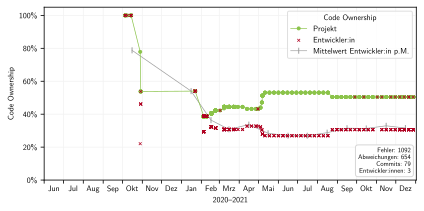

Projekt 11

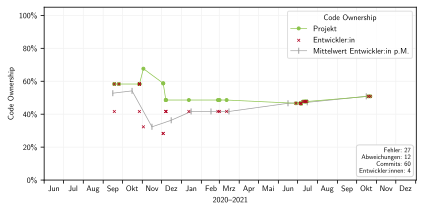

Projekt 16

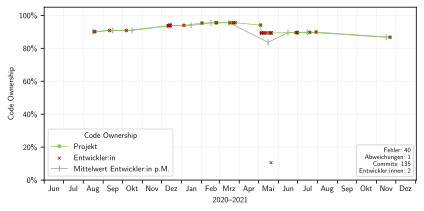

**Equivalentes Code Ownership**

Projekt 3

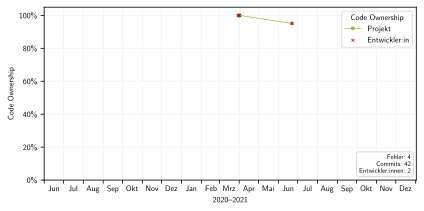

Projekt 5

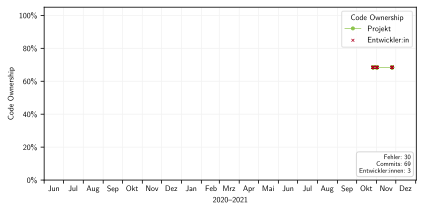

Projekt 7

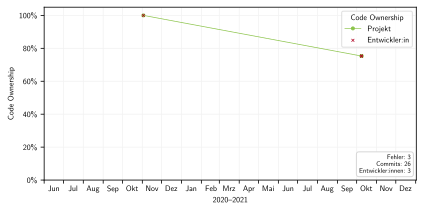

Projekt 9

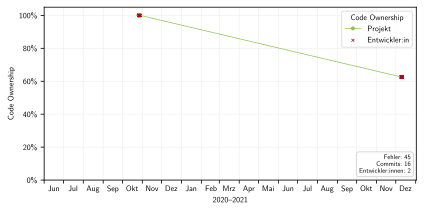

Projekt 10

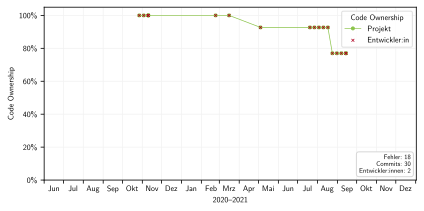

Projekt 12

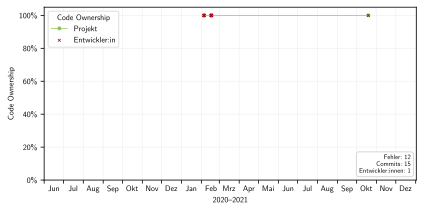

Projekt 14

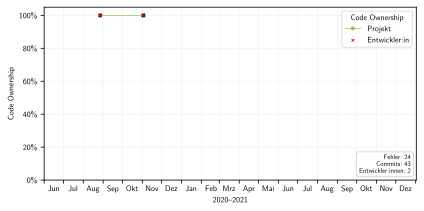

Projekt 15

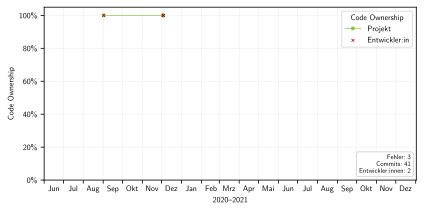

Projekt 17

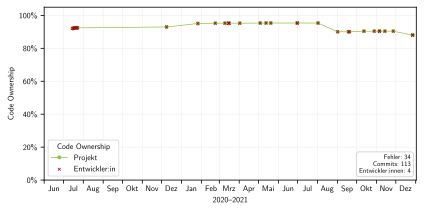

Projekt 18

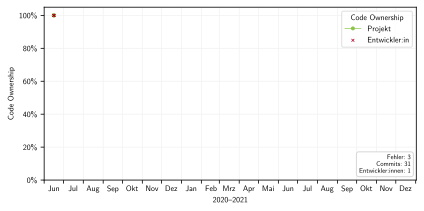

Projekt 19

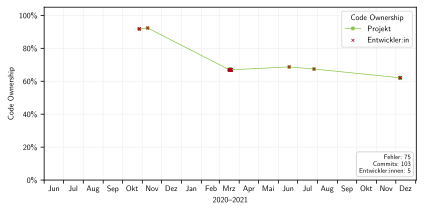

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = "svg"
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
from IPython.display import display, HTML, Markdown

plt.rc("font", **locals.FONT)

for category, categorized_result in results.items():

    if category == "deviating":
        display(Markdown("**Abweichendes Code Ownership**"))
    else:
        display(Markdown("**Equivalentes Code Ownership**"))

    for index, (project_id, result) in enumerate(categorized_result.items()):
        fig, ax = plt.subplots(figsize=(locals.TEXTWIDTH, 3))

        general_sorted = dict(sorted(result["general"].items()))
        author_sorted = dict(sorted(result["author"].items()))
        average_sorted = dict(sorted(result["average"].items()))

        ax.plot(list(general_sorted.keys()), list(general_sorted.values()), zorder=2,
            color=locals.MATERIAL_COLORS["lightgreen"], marker=".", linewidth=0.7, label="Projekt")
        ax.scatter(list(author_sorted.keys()), list(author_sorted.values()), zorder=3,
    color=locals.ERROR_COLOR_RED, marker="x", s=8, linewidth=0.7, label="Entwickler:in")

        if category == "deviating":
            ax.plot(list(average_sorted.keys()), list(average_sorted.values()),
                color=locals.MATERIAL_COLORS["gray"], marker="|", linewidth=0.7, label="Mittelwert Entwickler:in p.M.", zorder=1)
        
        legend = ax.legend(loc="best", title="Code Ownership", edgecolor=locals.FRAME_GRAY)

        ax.xaxis.set_major_locator(mdates.MonthLocator())
        ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonthday=16))
        ax.xaxis.set_major_formatter(mticker.NullFormatter())
        ax.xaxis.set_minor_formatter(mdates.DateFormatter("%b"))
        ax.yaxis.set_major_formatter(mticker.PercentFormatter(1.0))
        ax.tick_params(axis="x", which="minor", bottom=False, top=False, labelbottom=True)

        ax.margins(x=0.02)
        ax.set_xlabel(f"{min(years)}–{max(years)}")
        ax.set_ylabel("Code Ownership")
        ax.set_xlim([min(dates).replace(day=1), max(dates) + timedelta(days=5)])
        ax.set_ylim([0.0, 1.05])
        ax.grid(color=locals.GRID_GRAY)
        ax.set_axisbelow(True)

        annotation = f"Fehler: {len(general_sorted)}"

        if category == "deviating":
            general_values = list(general_sorted.values())
            author_values = list(author_sorted.values())
            deviation = 0
            for i in range(len(list(general_sorted.values()))):
                if general_values[i] != author_values[i]:
                    deviation += 1
            annotation += f"\nAbweichungen: {deviation}"
        
        annotation += f"\nCommits: {result['commits']}"
        annotation += f"\nEntwickler:innen: {result['authors']}"

        props = dict(boxstyle="round", facecolor="white", edgecolor=locals.FRAME_GRAY, pad=0.4)
        ax.text(0.985, 0.035, annotation, fontsize="small", bbox=props,
            horizontalalignment="right", verticalalignment="bottom", transform=ax.transAxes)

        display(Markdown(f"Projekt {locals.PROJECTS[project_id]['id']}"))
        plt.tight_layout()
        plt.show()

## Erstellung der Wertetabellen

Als letzter Schritt werden die entsprechenden Wertetabellen für die Teilprojekte angelegt.

In [3]:
from tabulate import tabulate

display(Markdown("**Wertetabellen**"))

for category, categorized_result in results.items():
    for project_id, result in categorized_result.items():

        display(Markdown(f"Projekt {locals.PROJECTS[project_id]['id']}"))

        table_headers = ["Datum", "Ownership Projekt", "Ownership Entwickler:in"]
        if category == "deviating":
            table_headers.append("Mittelwert Entwickler:in p.M.")
        
        table_results = {}

        for dt in result["general"].keys():
            if (date := dt.date()) not in table_results:
                table_results[date] = {
                    "general": [],
                    "author": []
                }
                if category == "deviating":
                    table_results[date]["average"] = result["average"][date.replace(day=16)]

            table_results[date]["general"].append(result["general"][dt])
            table_results[date]["author"].append(result["author"][dt])
        
        table_rows = []

        for date, table_result in dict(sorted(table_results.items())).items():
            row = [
                date.strftime("%d.%m.%Y"),
                ", ".join([f"{item:.2f} ({table_result['general'].count(item)})"
                    for item in set(table_result["general"])]),
                ", ".join([f"{item:.2f} ({table_result['author'].count(item)})"
                    for item in set(table_result["author"])])
            ]
            if "average" in table_result:
                row.append(f"{table_result['average']:.2f}")
            table_rows.append(row)
        
        display(HTML(tabulate(headers=table_headers,
            tabular_data=table_rows,
            tablefmt="html", stralign="center", numalign="center")))

**Wertetabellen**

Projekt 8

Datum,Ownership Projekt,Ownership Entwickler:in,Mittelwert Entwickler:in p.M.
05.10.2020,1.00 (5),1.00 (5),0.79
08.10.2020,1.00 (1),1.00 (1),0.79
14.10.2020,1.00 (4),1.00 (4),0.79
28.10.2020,0.78 (1),0.22 (1),0.79
29.10.2020,0.54 (5),"0.46 (4), 0.54 (1)",0.79
22.01.2021,0.54 (7),0.54 (7),0.54
04.02.2021,0.39 (361),"0.29 (24), 0.39 (337)",0.36
05.02.2021,0.39 (34),0.39 (34),0.36
09.02.2021,0.39 (35),0.39 (35),0.36
16.02.2021,0.41 (184),0.32 (184),0.36


Projekt 11

Datum,Ownership Projekt,Ownership Entwickler:in,Mittelwert Entwickler:in p.M.
18.09.2020,0.58 (2),"0.58 (1), 0.42 (1)",0.53
25.09.2020,0.58 (1),0.58 (1),0.53
27.10.2020,0.58 (4),"0.58 (3), 0.42 (1)",0.54
02.11.2020,0.68 (1),0.32 (1),0.32
03.12.2020,0.59 (2),0.28 (2),0.36
07.12.2020,0.49 (3),0.42 (3),0.36
12.01.2021,0.49 (1),0.42 (1),0.42
26.02.2021,0.49 (1),0.42 (1),0.42
01.03.2021,0.49 (1),0.42 (1),0.42
12.03.2021,0.49 (1),0.42 (1),0.42


Projekt 16

Datum,Ownership Projekt,Ownership Entwickler:in,Mittelwert Entwickler:in p.M.
18.08.2020,0.90 (1),0.90 (1),0.9
19.08.2020,0.90 (1),0.90 (1),0.9
11.09.2020,0.91 (1),0.91 (1),0.91
07.10.2020,0.91 (1),0.91 (1),0.91
11.12.2020,"0.94 (2), 0.94 (2)","0.94 (2), 0.94 (2)",0.94
13.12.2020,0.94 (1),0.94 (1),0.94
14.12.2020,0.94 (4),0.94 (4),0.94
04.01.2021,0.94 (1),0.94 (1),0.94
01.02.2021,0.95 (1),0.95 (1),0.95
23.02.2021,0.96 (1),0.96 (1),0.95


Projekt 3

Datum,Ownership Projekt,Ownership Entwickler:in
30.03.2021,1.00 (1),1.00 (1)
31.03.2021,1.00 (1),1.00 (1)
01.04.2021,1.00 (1),1.00 (1)
22.06.2021,0.95 (1),0.95 (1)


Projekt 5

Datum,Ownership Projekt,Ownership Entwickler:in
26.10.2021,0.68 (10),0.68 (10)
01.11.2021,0.68 (10),0.68 (10)
25.11.2021,0.68 (10),0.68 (10)


Projekt 7

Datum,Ownership Projekt,Ownership Entwickler:in
02.11.2020,1.00 (1),1.00 (1)
08.10.2021,0.75 (2),0.75 (2)


Projekt 9

Datum,Ownership Projekt,Ownership Entwickler:in
26.10.2020,1.00 (15),1.00 (15)
28.10.2020,1.00 (3),1.00 (3)
09.12.2021,0.63 (9),0.63 (9)
10.12.2021,0.63 (18),0.63 (18)


Projekt 10

Datum,Ownership Projekt,Ownership Entwickler:in
27.10.2020,1.00 (1),1.00 (1)
03.11.2020,1.00 (1),1.00 (1)
10.11.2020,1.00 (3),1.00 (3)
23.02.2021,1.00 (1),1.00 (1)
16.03.2021,1.00 (1),1.00 (1)
04.05.2021,0.93 (1),0.93 (1)
20.07.2021,0.93 (1),0.93 (1)
27.07.2021,0.93 (1),0.93 (1)
03.08.2021,0.93 (1),0.93 (1)
10.08.2021,0.93 (1),0.93 (1)


Projekt 12

Datum,Ownership Projekt,Ownership Entwickler:in
04.02.2021,1.00 (1),1.00 (1)
05.02.2021,1.00 (3),1.00 (3)
16.02.2021,1.00 (7),1.00 (7)
19.10.2021,1.00 (1),1.00 (1)


Projekt 14

Datum,Ownership Projekt,Ownership Entwickler:in
27.08.2020,1.00 (8),1.00 (8)
02.11.2020,1.00 (16),1.00 (16)


Projekt 15

Datum,Ownership Projekt,Ownership Entwickler:in
01.09.2020,1.00 (1),1.00 (1)
03.12.2020,1.00 (2),1.00 (2)


Projekt 17

Datum,Ownership Projekt,Ownership Entwickler:in
15.07.2020,0.92 (1),0.92 (1)
16.07.2020,0.92 (1),0.92 (1)
17.07.2020,0.92 (1),0.92 (1)
18.07.2020,0.92 (1),0.92 (1)
19.07.2020,0.92 (1),0.92 (1)
20.07.2020,0.92 (1),0.92 (1)
21.07.2020,0.92 (1),0.92 (1)
22.07.2020,0.92 (1),0.92 (1)
23.07.2020,0.92 (1),0.92 (1)
08.12.2020,0.93 (1),0.93 (1)


Projekt 18

Datum,Ownership Projekt,Ownership Entwickler:in
16.06.2020,1.00 (3),1.00 (3)


Projekt 19

Datum,Ownership Projekt,Ownership Entwickler:in
27.10.2020,0.92 (2),0.92 (2)
09.11.2020,0.92 (1),0.92 (1)
16.03.2021,0.67 (10),0.67 (10)
17.03.2021,0.67 (24),0.67 (24)
18.03.2021,0.67 (24),0.67 (24)
19.03.2021,0.67 (9),0.67 (9)
17.06.2021,0.69 (1),0.69 (1)
26.07.2021,0.67 (1),0.67 (1)
07.12.2021,0.62 (3),0.62 (3)
